# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# 1D example

In [3]:
def f_1d_toy(x):
    if 2 <= x.item() <= 3:
        f = \
            -1600 * (x - 2.5) ** 5 - \
            2000 * (x - 2.5) ** 4 + \
            800 * (x - 2.5) ** 3 + \
            1020 * (x - 2.5) ** 2 

    elif 8.4 <= x.item() <= 8.40001:
        f = 1411.2 * (1 - 1e4 * (x - 8.4))

    elif 8.40001 <= x.item() <= 8.59999:

        f = x * 0

    elif 8.59999 <= x.item() <= 8.6:
        f = 1479.2 * (1e4 * (x - 8.6) + 1)

    else:
        f = 20 * x ** 2

    return f

In [4]:
xs = np.arange(-2, 10, 1e-3)
xs_torch = [torch.tensor([x]) for x in xs]
ys_torch = [f_1d_toy(x) for x in xs_torch]
ys = [y.item() for y in ys_torch]

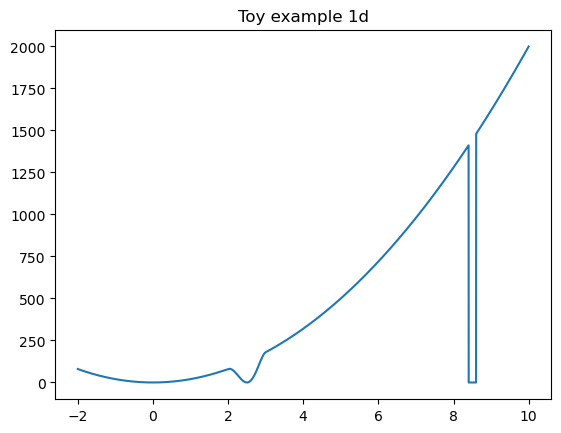

In [5]:
plt.plot(xs, ys)
plt.title('Toy example 1d')
plt.show()

In [6]:
torch.ones_like(torch.zeros(3)) * 0 / 0

tensor([nan, nan, nan])

In [7]:
def run_gd(func, lr, x_start_value, max_iter, return_null_if_fail=False):
    x = torch.tensor(x_start_value, requires_grad=True)
    optimizer = optim.SGD([x], lr=lr)
    x_hist_torch = []

    n_iter = 0

    while len(x_hist_torch) == 0 or \
        torch.norm(x - x_hist_torch[-1]) > 1e-6 and \
        n_iter < max_iter:

        x_hist_torch.append(x.detach().clone())

        optimizer.zero_grad()
        func(x).backward()

        optimizer.step()
        n_iter += 1

    x_hist_torch.append(x.detach().clone())

    if n_iter >= max_iter and return_null_if_fail:
        x_hist_torch.append(torch.zeros_like(x) / 0)

    return x_hist_torch

In [8]:
def plot_1d_gd(lr, start_point, max_iter=1e3):

    xs = np.arange(-2, 10, 1e-3)
    xs_torch = [torch.tensor([x]) for x in xs]
    ys_torch = [f_1d_toy(x) for x in xs_torch]
    ys = [y.item() for y in ys_torch]
    
    plt.style.use('default')
    plt.plot(xs, ys)

    x_hist_torch = run_gd(f_1d_toy, lr, [start_point], max_iter)
    y_hist_torch = [f_1d_toy(x) for x in x_hist_torch]
    x_hist = [x.item() for x in x_hist_torch]
    y_hist = [y.item() for y in y_hist_torch]

    plt.style.use('seaborn-dark-palette')
    plt.scatter(x_hist, y_hist, c=range(len(x_hist)))
    plt.title(f'Toy example 1d lr={lr}')
    plt.show()

/tmp/ipykernel_10099/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


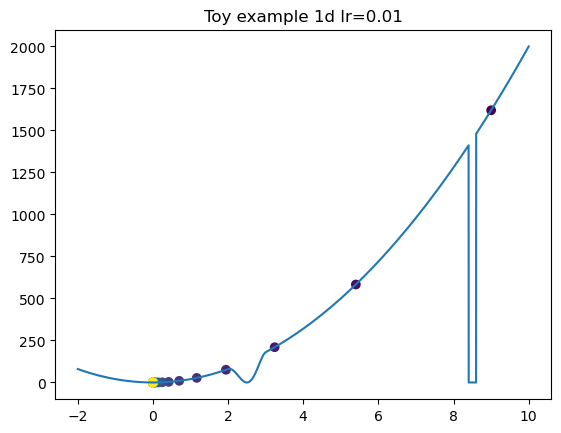

/tmp/ipykernel_10099/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


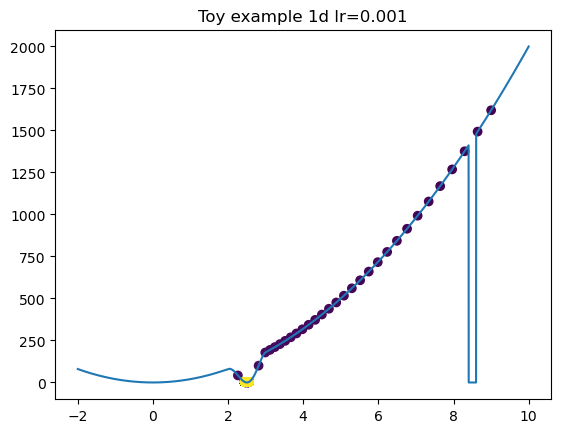

/tmp/ipykernel_10099/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


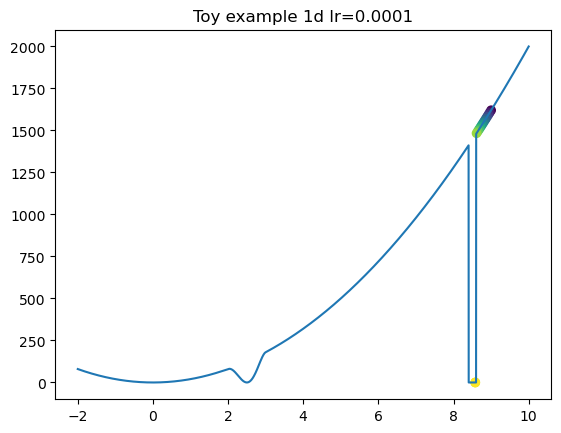

In [9]:
plot_1d_gd(1e-2, 9.)
plot_1d_gd(1e-3, 9.)
plot_1d_gd(1e-4, 9.)

In [10]:
import scipy.stats as ss
from itertools import product
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

In [11]:
lrs = np.logspace(-4, -2, 15)
x_starts = np.linspace(8.5, 10, 20)
x_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)

for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    x_ends[lr_i, x_start_i] = run_gd(f_1d_toy, lr, [x_start], 1e3, return_null_if_fail=True)[-1].item()


0it [00:00, ?it/s]

In [12]:
x_ends_df = pd.DataFrame(x_ends, columns=x_starts).assign(lrs=lrs)
x_ends_df = x_ends_df.melt(id_vars='lrs', var_name='x_start', value_name='x_end')
x_ends_df

,lrs,x_start,x_end
0,0.000100,8.5,8.500000e+00
1,0.000139,8.5,8.500000e+00
2,0.000193,8.5,8.500000e+00
3,0.000268,8.5,8.500000e+00
4,0.000373,8.5,8.500000e+00
...,...,...,...
295,0.002683,10.0,7.692986e-06
296,0.003728,10.0,8.508963e+00
297,0.005179,10.0,3.223516e-06
298,0.007197,10.0,1.838036e-06


In [13]:
def x_end_to_type(x):
    if np.isnan(x):
        return 'No convergence in 1000 iterations'

    if -1e-2 < x < 1e-2:
        return 'global min'
    
    elif -1e-2 < x - 2.5 < 1e-2:
        return 'local min'
    
    elif -8.4 < x < 8.6:
        return 'sharp local min near start'

    else:
        return 'something else' 


x_ends_df['x_end_type'] = x_ends_df['x_end'].apply(x_end_to_type)

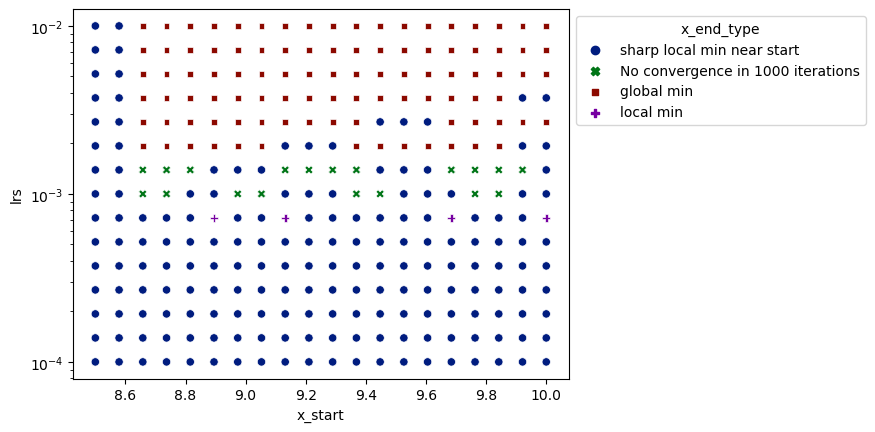

In [14]:
ax = sns.scatterplot(
    data=x_ends_df, 
    x='x_start', 
    y='lrs', 
    hue='x_end_type', 
    style='x_end_type',
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.yscale('log')
plt.show()

# 2D example

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [16]:
import torch.nn.functional as F

In [17]:
def f_2d_toy(x, y):
    f_A = x ** 2 + y ** 2
    f_B = 200 * \
        F.relu(torch.abs(x) - 1) * \
        F.relu(torch.abs(y) - 1) * \
        F.relu(2 - torch.abs(x)) * \
        F.relu(2 - torch.abs(y))

    return f_A - f_B

In [18]:
x = torch.linspace(-3, 3, 40)
y = torch.linspace(-3, 3, 40)

grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

In [19]:
grid_z = f_2d_toy(grid_x, grid_y)

In [20]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.05, [3., 2.5], max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()

In [21]:
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ],
)

fig.update_layout(
    title={
        'text': f'GD converged to flat minima lr=0.01', 
        'x':0.5,
        'xanchor': 'center',
    }
)

fig.show()

In [22]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.005, [3., 2.5], max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ]
)

fig.update_layout(
    title={
        'text': f'GD converged to sharp minima lr=0.005', 
        'x':0.5,
        'xanchor': 'center',
    }
)


fig.show()

In [23]:
lrs = np.logspace(-2, -1, 20)

x_starts = np.random.uniform(3, 4, size=(40, 2))
x_ends = np.zeros((len(lrs), len(x_starts), 2), dtype=float)
z_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)


for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    ends = run_gd(lambda x: f_2d_toy(x[0], x[1]), lr, x_start, 1e3)[-1]
    x_ends[lr_i, x_start_i] = ends.numpy()
    z_ends[lr_i, x_start_i] = f_2d_toy(ends[0], ends[1]).item()


0it [00:00, ?it/s]

In [24]:
z_ends_df = pd.DataFrame(z_ends, columns=[f'x_start_{i}' for i in range(len(x_starts))])
z_ends_df['lr'] = lrs

In [25]:
z_ends_df = z_ends_df.melt(id_vars='lr', value_vars=[f'x_start_{i}' for i in range(len(x_starts))])

In [26]:
z_ends_df['log_lr'] = np.log10(z_ends_df['lr']).round()

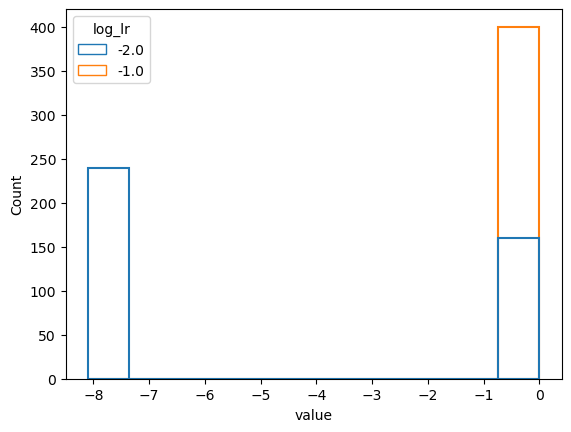

In [27]:
sns.histplot(data=z_ends_df, x='value', hue='log_lr', palette='tab10', fill=False)
plt.show()

In [28]:
def map_val_to_type(z):
    if z < -8:
        return 'sharp minima'

    elif -1e-2 < z < 1e-2:
        return 'flat minima'
    
    else:
        return 'did not converge'

z_ends_df['type_gd'] = z_ends_df['value'].apply(map_val_to_type)

In [29]:
frac_counter = z_ends_df.query('type_gd == "flat minima"').groupby('lr').size() / z_ends_df.groupby('lr').size()
frac_counter.fillna(0, inplace=True)
frac_counter = frac_counter.to_frame(name='fraction of flat minima').reset_index()

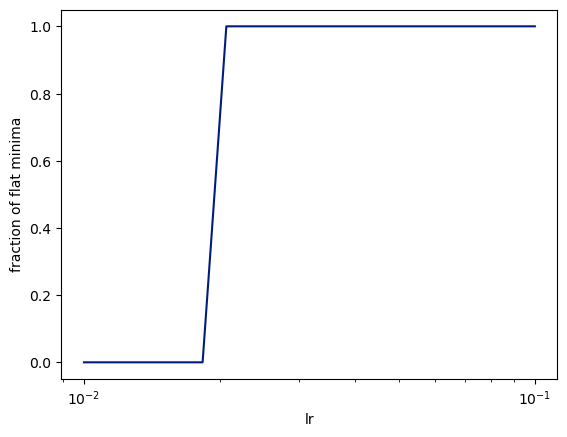

In [30]:
sns.lineplot(data=frac_counter, x='lr', y='fraction of flat minima')
plt.xscale('log')
plt.show()

# NN example

In [31]:
import seaborn_image as isns
from torch import nn

In [32]:
torch.cuda.is_available()

True

In [33]:
device = torch.device("cuda")

# Mnist

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 100
trainset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)

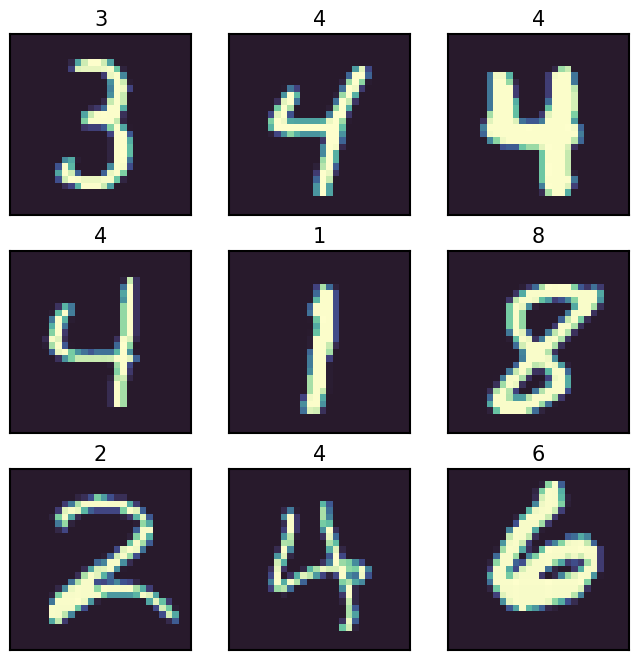

In [35]:
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, j in product(range(rows), range(cols)):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    sample_img , sample_lbl = trainset[sample_idx]

    axs[i, j].set_title(sample_lbl)
    isns.imgplot(sample_img.numpy()[0][::-1], ax=axs[i, j], cbar=False)

plt.show()

In [36]:
class MyLittleNN(nn.Module):
    def __init__(self):
        super(MyLittleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

In [37]:
def train(dataloader, model, loss_fn, optimizer, save_params=0):
    size = 0
    
    model.train()
    
    batch_loss = []
    batch_accuracy = []

    if save_params > 0:
        params_hist = [] 
    
    correct = 0
    _correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)
        
        correct += _correct
        
        # Updating loss_batch and batch_accuracy
        batch_loss.append(loss.item())
        batch_accuracy.append(_correct/_batch_size)
        
        size += _batch_size
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")

        if save_params > 0 and batch % save_params == 0:
            params_hist.append( 
                np.concatenate([p.cpu().detach().numpy().reshape(-1) for p in model.parameters()]) 
            )
            
    
    correct /= size
    print(f"Train Accuracy: {(100*correct):>0.1f}%")
    
    return batch_loss, batch_accuracy, params_hist

In [38]:
def validation(dataloader, model, loss_fn):
    
    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)
    
    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = []
    batch_accuracy = []
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss.append(loss_fn(pred, y).item())
            test_loss += batch_loss[-1]
            
            _batch_size = len(X)
            
            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy.append(_correct/_batch_size)
            
    test_loss /= num_batches
    
    correct /= size
    
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return batch_loss, batch_accuracy

In [39]:
losses_df = pd.DataFrame(columns=['epoch', 'type', 'batch', 'loss', 'accuracy', 'lr'])
params_hist = {}

In [42]:
def train_epochs(learning_rate):
    model = MyLittleNN().to(device)
    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    params_hist[learning_rate] = []

    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        _train_batch_loss , _train_batch_accuracy, _params_hist = train(
            trainloader, 
            model, 
            loss_fn, 
            optimizer, 
            save_params=10
        )

        _valid_batch_loss , _valid_batch_accuracy = validation(
            testloader, 
            model, 
            loss_fn
        )

        params_hist[learning_rate] += _params_hist

        train_length = len(_train_batch_loss)
        valid_length = len(_valid_batch_loss)

        train_losses_df = pd.DataFrame(
            data={
                'epoch': [t] * train_length,
                'type': ['train'] * train_length,
                'batch': list(range(train_length)),
                'loss': _train_batch_loss,
                'accuracy': _train_batch_accuracy,
                'lr': [learning_rate] * train_length,
            }
        )

        valid_losses_df = pd.DataFrame(
            data={
                'epoch': [t] * valid_length,
                'type': ['valid'] * valid_length,
                'batch': list(range(valid_length)),
                'loss': _valid_batch_loss,
                'accuracy': _valid_batch_accuracy,
                'lr': [learning_rate] * valid_length,
            }
        )

        global losses_df
        losses_df = pd.concat([losses_df, train_losses_df, valid_losses_df])

In [ ]:
train_epochs(5e-3)
train_epochs(5e-2)
train_epochs(1e-1)

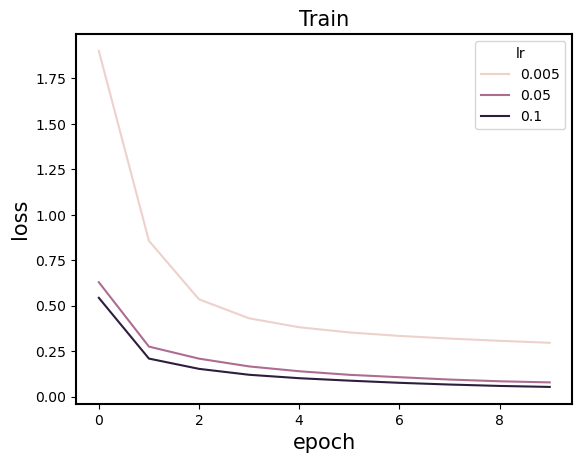

In [44]:
plt.title('Train')
sns.lineplot(
    data=losses_df\
        .query('type == "train"')\
        .groupby(['epoch', 'lr'], as_index=False)\
        ['loss']\
        .mean(),
    x='epoch',
    y='loss',
    hue='lr'
)

plt.show()

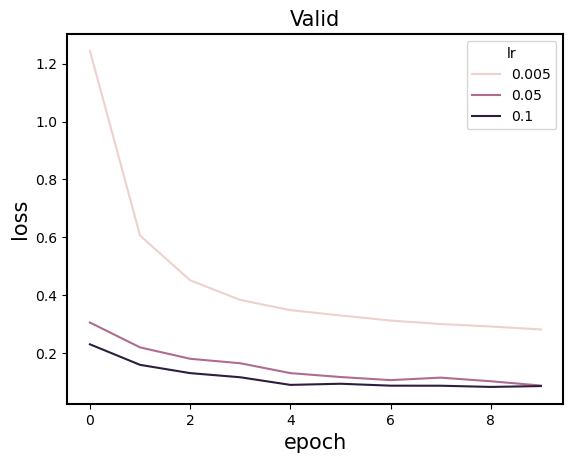

In [45]:
plt.title('Valid')
sns.lineplot(
    data=losses_df\
        .query('type == "valid"')\
        .groupby(['epoch', 'lr'], as_index=False)\
        ['loss']\
        .mean(),
    x='epoch',
    y='loss',
    hue='lr'
)

plt.show()

In [49]:
params_hist_df = []
for lr, params in params_hist.items():
    params_hist_df.append(
        pd.DataFrame(
            data=params, 
            columns=[f'param_{i + 1}' for i in range(len(params[0]))]
        ).assign(lr=lr)
    )

params_hist_df = pd.concat(params_hist_df)

In [55]:
params_hist_df.reset_index(inplace=True)
params_hist_df.rename(columns={'index': 'step'}, inplace=True)

In [56]:
from sklearn.decomposition import PCA

In [57]:
len(params_hist_df)

1800

In [58]:
pca = PCA(n_components=2)
X = pca.fit_transform(params_hist_df.drop(['lr', 'step'], axis=1))

In [59]:
pca.explained_variance_ratio_

array([0.56016296, 0.3914124 ], dtype=float32)

In [63]:
params_hist_df.query('step == 0')

,step,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,param_9,...,param_109378,param_109379,param_109380,param_109381,param_109382,param_109383,param_109384,param_109385,param_109386,lr
0,0,0.007177,0.018025,0.015141,0.017634,0.007001,-0.003164,-0.003928,0.006196,-0.002645,...,0.027319,-0.017645,0.008704,0.123049,-0.023559,-0.089906,-0.039757,-0.039821,-0.006309,0.005
600,0,0.026341,0.035247,0.014923,0.016197,0.006607,0.003203,-0.024916,-0.032623,-0.023209,...,0.079581,-0.084336,-0.095950,0.070101,-0.017816,-0.008737,-0.080869,-0.085845,0.046805,0.050
1200,0,-0.003061,0.004438,-0.025820,0.024002,-0.013486,-0.016306,0.028661,-0.004927,0.025634,...,-0.019228,0.049488,-0.115439,-0.118017,-0.095541,-0.076565,-0.115856,0.020645,0.104298,0.100


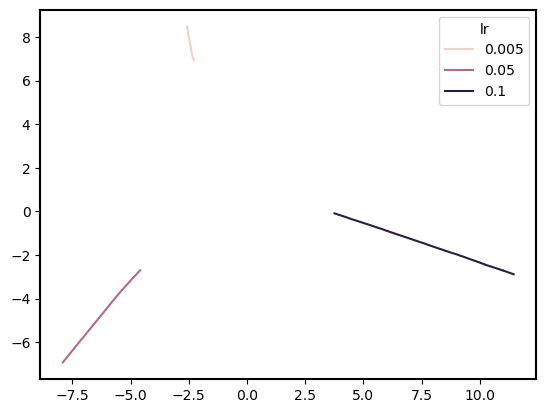

In [62]:
sns.lineplot(x=X[:, 0], y=X[:, 1], hue=params_hist_df['lr'])
plt.show()